# Deep Learning with PyTorch : Build a Generative Adversarial Network 

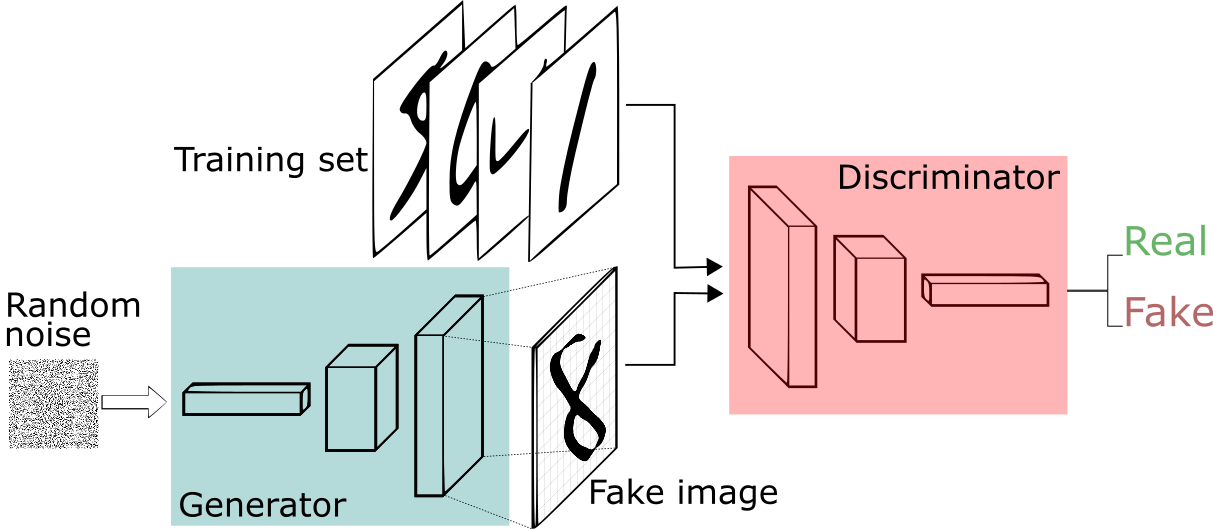

In [1]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 128

noise_dim = 64  # used in generator

# optimizes' parameters
lr = 0.0002
beta_1 = 0.5
beta_2 =.099

# training variables
epochs = 20

In [3]:
device

'cuda'

# Load MNIST Dataset 

In [4]:
from torchvision import datasets, transforms as T

In [5]:
train_augs = T.Compose([
      T.RandomRotation((-20, 20)),
      T.ToTensor()  # shift dim: (h, w, c) --> (c, h, w)
])

In [6]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



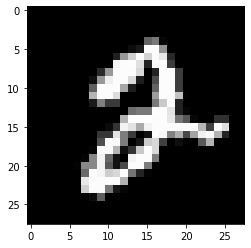

In [7]:
image, label = trainset[5]

plt.imshow(image.squeeze(), cmap='gray')

In [8]:
print('Total images in trainset:', len(trainset))

Total images in trainset: 60000


# Load Dataset Into Batches 

In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [10]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [11]:
print('Total number of batches in trainloader:', len(trainloader))

Total number of batches in trainloader: 469


In [12]:
dataiter = iter(trainloader)

images, _ = dataiter.next()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [13]:
# 'show_tensor_images' : function is used to plot some of images from the batch
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

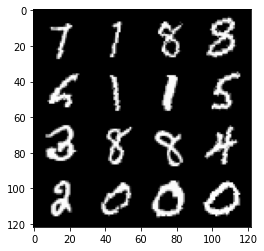

In [14]:
show_tensor_images(images, num_images=16)

# Create Discriminator Network 

In [ ]:
#In case if torch summary is not installed 
# !pip install torchsummary

In [15]:
from torch import nn
from torchsummary import summary

In [16]:
'''

Network : Discriminator

input : (batch_size, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(batch_size, 16, 13, 13)
BatchNorm2d()                                                                                          #(batch_size, 16, 13, 13)
LeakyReLU()                                                                                            #(batch_size, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(batch_size, 32, 5, 5)
BatchNorm2d()                                                                                          #(batch_size, 32, 5, 5)
LeakyReLU()                                                                                            #(batch_size, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(batch_size, 64, 1, 1)
BatchNorm2d()                                                                                          #(batch_size, 64, 1, 1)
LeakyReLU()                                                                                            #(batch_size, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(batch_size, 64)
Linear(in_features = 64, out_features = 1)                                                             #(batch_size, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (batch_size, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(batch_size, 16, 13, 13)\nBatchNorm2d()                                                                                          #(batch_size, 16, 13, 13)\nLeakyReLU()                                                                                            #(batch_size, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(batch_size, 32, 5, 5)\nBatchNorm2d()                                                                                          #(batch_size, 32, 5, 5)\nLeakyReLU()                                                                                            #(batch_size, 32, 5, 5)\n      |\n    

In [17]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [18]:
class Discriminator(nn.Module):
  def __init__(self) -> None:
    super(Discriminator, self).__init__()
    
    self.block_1 = get_disc_block(1, 16, (3, 3), 2)
    self.block_2 = get_disc_block(16, 32, (5, 5), 2)
    self.block_3 = get_disc_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64, out_features=1) # no need sigmoid since use binary_crossentropy with logit loss (take raw output)
    
  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [19]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [21]:
'''

Network : Generator 

z_dim = 64
input : (batch_size, z_dim)

      |
      | Reshape
      V

input : (batch_size, channel, height, width) -> (batch_size, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(batch_size, 256, 3, 3)
BatchNorm2d()                                                                                          #(batch_size, 256, 3, 3)
ReLU()                                                                                                 #(batch_size, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(batch_size, 128, 6, 6)
BatchNorm2d()                                                                                          #(batch_size, 128, 6, 6)
ReLU()                                                                                                 #(batch_size, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(batch_size, 64, 13, 13)
BatchNorm2d()                                                                                          #(batch_size, 64, 13, 13)
ReLU()                                                                                                 #(batch_size, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(batch_size, 1, 28, 28)
Tanh()                                                                                                 #(batch_size, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (batch_size, z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (batch_size, channel, height, width) -> (batch_size, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(batch_size, 256, 3, 3)\nBatchNorm2d()                                                                                          #(batch_size, 256, 3, 3)\nReLU()                                                                                                 #(batch_size, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(batch_size, 128, 6, 6)\nBatchNorm2d()                                                                                          #(batch_size, 128, 6, 6)\nReLU()              

In [22]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [23]:
class Generator(nn.Module):
  def __init__(self, noise_dim) -> None:
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3, 3), 2, False)
    self.block_2 = get_gen_block(256, 128, (4, 4), 1, False)
    self.block_3 = get_gen_block(128, 64, (3, 3), 2, False)
    self.block_4 = get_gen_block(64, 1, (4, 4), 2, True)
  
  def forward(self, rand_noise_vec):
    # rand_noise_vec.shape = (bs, noise_dim) --> (bs, noise_dim, 1, 1)
    x= rand_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [24]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [25]:
# Replace Random initialized weights to Normal weights  
def weights_init(m):  
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, 0.0, 0.02)
    nn.init.constant_(m.bias, 0)

In [26]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [27]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [28]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

# Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 	 D_loss: 0.6861202280912826 	 G_loss: 0.6934435722161966


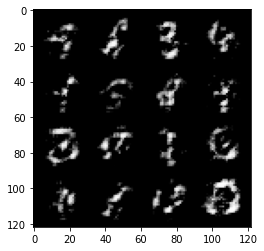

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 	 D_loss: 0.6820801768475758 	 G_loss: 0.7076839363651235


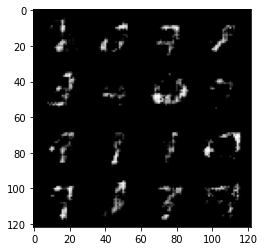

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 	 D_loss: 0.6620073741687132 	 G_loss: 0.7366897343064168


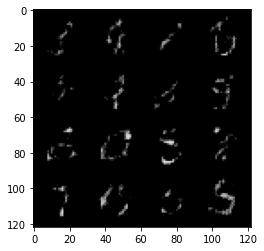

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 	 D_loss: 0.6235693818978918 	 G_loss: 0.784742698359337


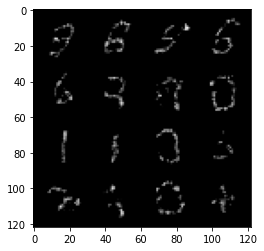

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 	 D_loss: 0.5759802934711676 	 G_loss: 0.8573498680139147


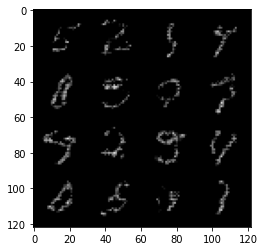

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 	 D_loss: 0.552023463538969 	 G_loss: 0.9219282927797802


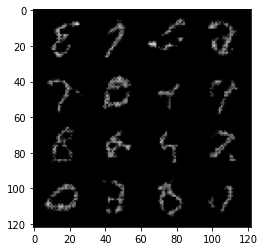

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 	 D_loss: 0.5520095438845376 	 G_loss: 0.9520651456643777


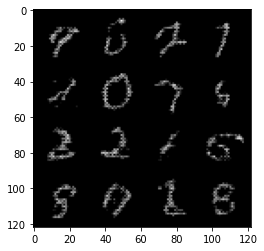

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 	 D_loss: 0.5484889518858781 	 G_loss: 0.9666426235170507


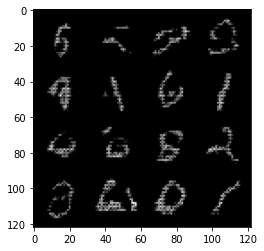

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 	 D_loss: 0.5506219798440872 	 G_loss: 0.9836529151463052


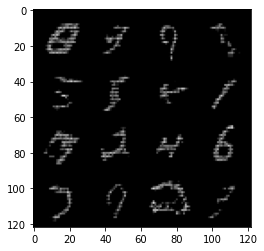

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 	 D_loss: 0.5668882666620364 	 G_loss: 0.9876798012617555


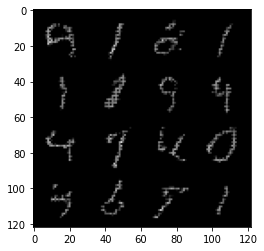

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 	 D_loss: 0.5797384421962665 	 G_loss: 0.972094327529102


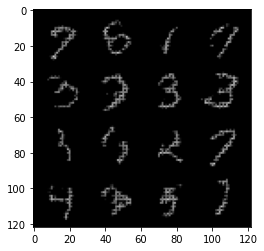

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 	 D_loss: 0.6005441644298497 	 G_loss: 0.9449079977169729


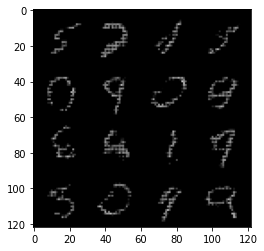

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 	 D_loss: 0.6132050986483153 	 G_loss: 0.9231407728784883


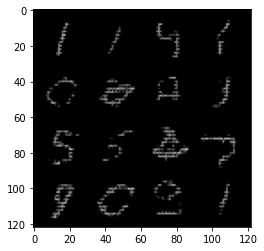

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 	 D_loss: 0.6207493646566802 	 G_loss: 0.9155574552794256


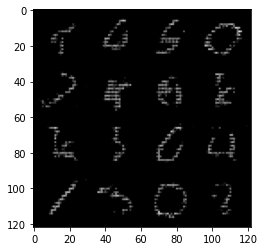

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 	 D_loss: 0.6282396950701407 	 G_loss: 0.8943341253662923


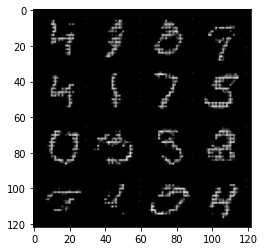

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 	 D_loss: 0.6245194714206622 	 G_loss: 0.8968272557390778


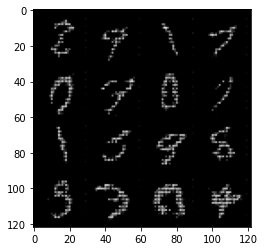

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 	 D_loss: 0.6057254483959059 	 G_loss: 0.9390337201578023


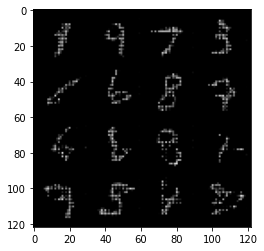

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 	 D_loss: 0.5975251449450755 	 G_loss: 0.9554015230268303


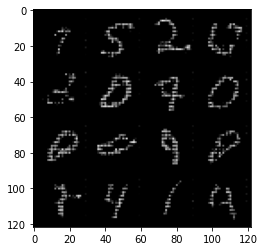

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 	 D_loss: 0.5933804656905152 	 G_loss: 0.9702231026153321


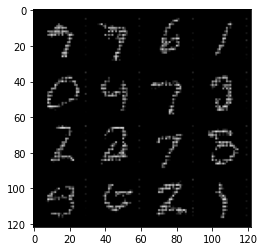

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 	 D_loss: 0.5978757426428642 	 G_loss: 0.9654755641910822


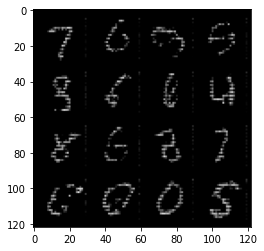

In [29]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    # find loss + update weights for D
    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2.0
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # find loss + update weights for G
    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device=device)
    
    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)  # want to generate as real as possible
    total_g_loss += G_loss.item()
    
    G_loss.backward()
    G_opt.step()
  
  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print('Epoch: {} \t D_loss: {} \t G_loss: {}'.format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

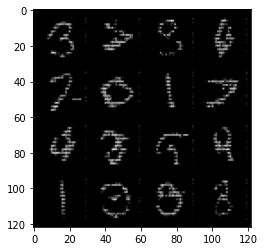

In [30]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya